# Решение задачи классификации отзывов на женскую одежду при помощи библиотеки transformers.

Набор данных магазинов женской одежды, основанный на отзывах, написанных покупателями.

[Kaggle: Women's E-Commerce Clothing Reviews](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

# Описание таблицы с данными

Этот набор данных включает 23 486 строк и 10 переменных признаков. Каждая строка соответствует отзыву клиента и включает переменные:

- **Clothing ID**: Целое число, категориальная переменная, которая относится к конкретному проверяемому товару;
- **Age**: Положительная целочисленная переменная возраста рецензента;
- **Title**: Строковая переменная для названия заголовка;
- **Review Text**: Строковая переменная для тела отзыва;
- **Rating**: Положительное порядковое целое число, обозначающее оценку продукта, присвоенную клиентом, от 1 худшего до 5 лучших;
-**Recommended IND**: Двоичная переменная, указывающая, рекомендации кленента относительно продукта. Рекомендует - 1, не рекомендует - 0;
- **Positive Feedback Count**: Положительное целое число, фиксирующее количество других клиентов, которые сочли этот отзыв положительным;
- **Division Name**: Категориальное имя подразделения продукта;
- **Department Name**: Категориальное название отдела продукта;
- **Class Name**: : Категориальное имя класса продукта.


# 1 Загрузка библиотек

In [ ]:
!pip install -qq pymorphy2 pymorphy2-dicts >> None

!pip install -qq transformers datasets >> None
!pip install pyarrow >> None

In [ ]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import load_dataset, load_metric
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from transformers import (
    AdamW,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_scheduler,
)

# 2 Загрузка данных

In [ ]:
!gdown --id 1tnAZgvxszZbRX0lXKdCD_9T-5ifuX8Eh
!mkdir data
!unzip ./Womens-Clothing-E-Commerce-Reviews.zip -d data
!rm ./Womens-Clothing-E-Commerce-Reviews.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tnAZgvxszZbRX0lXKdCD_9T-5ifuX8Eh
To: /content/Womens-Clothing-E-Commerce-Reviews.zip
100% 2.71M/2.71M [00:00<00:00, 26.6MB/s]
Archive:  ./Womens-Clothing-E-Commerce-Reviews.zip
  inflating: data/Womens Clothing E-Commerce Reviews.csv  


# 3 Исследовательский анализ данных

In [ ]:
PATH_DATA = "./data"

In [ ]:
df_full = pd.read_csv(
    f"{PATH_DATA}/Womens Clothing E-Commerce Reviews.csv", index_col=[0]
)

In [ ]:
df_full.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
print("Число (строк, столбцов): " + str(df_full.shape))

Число (строк, столбцов): (23486, 10)


Оставим необходимые нам на данный момент столбцы:

In [ ]:
df = df_full[["Review Text", "Recommended IND"]].copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review Text      22641 non-null  object
 1   Recommended IND  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 550.5+ KB


In [ ]:
df.describe(include="all")

,Review Text,Recommended IND
count,22641,23486.000000
unique,22634,NaN
top,Perfect fit and i've gotten so many compliment...,NaN
freq,3,NaN
mean,NaN,0.822362
std,NaN,0.382216
min,NaN,0.000000
25%,NaN,1.000000
50%,NaN,1.000000
75%,NaN,1.000000


### 3.1 Исследуем столбец с числовыми переменными


In [ ]:
# Определим числовые переменные
numerical = [var for var in df.columns if df[var].dtype != "O"]

print("Всего {} числовых переменных\n".format(len(numerical)))
print("Числовые переменные:", numerical)

Всего 1 числовых переменных

Числовые переменные: ['Recommended IND']


In [ ]:
# Количество уникальных значений
df[numerical].nunique()

Recommended IND    2
dtype: int64

In [ ]:
# Основные статистики
df[numerical].describe()

,Recommended IND
count,23486.000000
mean,0.822362
std,0.382216
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


__Пропущенные значения__

In [ ]:
# Оценим долю пропущенных значений в стобце числовых переменных
for col in numerical:
    if df[col].isnull().mean() > 0:
        prop_miss = round(df_full[col].isnull().mean(), 4)
        print(f"Пропуски в столбце: {col}. Доля пропущенных значений: {prop_miss}")

__Сводка по числовым переменным__

Всего 1 столбец числовых пермеменных:
- `Recommended IND` - он же, целевая переменная;
- Пропуски отсутствуют;
- Выбросов нет.

### 3.2 Исследование столбца с категориальными переменными

In [ ]:
categorical = df.select_dtypes(include="object").columns.to_list()

print("Всего {} категориальных переменных\n".format(len(categorical)))
print("Категориальные переменные:", categorical)

Всего 1 категориальных переменных

Категориальные переменные: ['Review Text']


In [ ]:
df[categorical].nunique()

Review Text    22634
dtype: int64

In [ ]:
# Посмотрим на основные статистики
df_full[categorical].describe()

,Review Text
count,22641
unique,22634
top,Perfect fit and i've gotten so many compliment...
freq,3


__Пропущенные значения__

In [ ]:
df[categorical].isnull().sum()

Review Text    845
dtype: int64

In [ ]:
# Оценим долю пропущенных значений в стобцах числовых переменных
for col in categorical:
    if df[col].isnull().mean() > 0:
        prop_miss = round(df[col].isnull().mean(), 4)
        print(f"Пропуски в столбце: {col}. Доля пропущенных значений: {prop_miss}")

Пропуски в столбце: Review Text. Доля пропущенных значений: 0.036


__Сводка по категориальным переменным__

- Имеется 1 столбцец категориальных переменных;
- Пропущенные значения в столбце `Review Text` ~ 3.6%.

# 4 Обработка признаков

### 4.1 Обработка числовых переменных

Тут все хорошо, единственный столбец `Recommended IND` трогать не будем.

## 4.2 Обработка категориальных переменных

In [ ]:
# Удалим строки с пропущенными значениями "Review Text"
print("Число строк до удаления пропусков: ", df.shape[0])
df.dropna(subset=["Review Text"], inplace=True)
print("Число строк после удаления пропусков: ", df.shape[0])

Число строк до удаления пропусков:  23486
Число строк после удаления пропусков:  22641


__Дубликаты__

In [ ]:
# Проверим на дубликаты
duplicates = df.duplicated().sum()
if duplicates == 0:
    print("В данных нет дулбикатов строк")
else:
    print("Всего: ", str(duplicates), " дубликатов строк")

Всего:  7  дубликатов строк


In [ ]:
# Удалим все дубликаты
df = df[~df.duplicated(keep="first")].reset_index(drop=True).copy()

In [ ]:
df.shape

(22634, 2)

__Очистка текста в столбце `Review Text`__

In [ ]:
# Загрузить необходимые ресурсы из nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Инициализация лемматизатора и стоп-слов
lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words("english"))


# Функция для предобработки текста
def preprocess_text(text):
    # Приводим текст к нижнему регистру
    text = text.lower()

    # Удаляем никнеймы, хэштеги, URL-адреса и символы новой строки
    text = re.sub(r"@\w+|#[\w-]+|http\S+|\n", "", text)

    # Удаляем пунктуацию, не разделяя слова и знаки препинания
    text = re.sub(r"[^\w\s]", " ", text)

    # Токенизируем текст для более точного разделения на слова
    words = word_tokenize(text)

    # Фильтрация слов, состоящих только из подчеркиваний
    words = [word for word in words if not re.match(r"^_+$", word)]

    # Инициализация списка для лемматизированных слов
    processed_words = []

    for word in words:
        try:
            # Лемматизация слова
            word = lemmatizer.lemmatize(word)
        except:
            # Если лемматизация не удастся, используем исходное слово
            pass

        # Исключение стоп-слов (можно сделать опциональным)
        if word not in english_stopwords:
            processed_words.append(word)

    # Соединяем обработанные слова в строку
    return " ".join(processed_words)


# Пример использования функции на случайных строках датафрейма
for i in np.random.randint(0, len(df), 5):
    print("Ориг:", df["Review Text"][i])
    print("Чист:", preprocess_text(df["Review Text"][i]), "\n")

Ориг: I love all my retailer clothes! it's my favorite store! i even love the displays!
Чист: love retailer clothes favorite store even love display 

Ориг: As soon as i opened the package, i knew that this is going to be my all time retailer favorite. many reviewers mentioned how puffy the sleeves are but i see it as quite proportioned with the rest of the dress. tts i am 5'5" and 128lb, ps fits perfect. i am an addict of retailer dress <3
Чист: soon opened package knew going time retailer favorite many reviewer mentioned puffy sleeve see quite proportioned rest dress tt 5 5 128lb p fit perfect addict retailer dress 3 

Ориг: I think this shawl is much more stunning on than on the hanger. i think it will be a great piece to transition into fall, wearing it over a black or white tee. it can be dressed up or down. especially for the sale price, a great piece!
Чист: think shawl much stunning hanger think great piece transition fall wearing black white tee dressed especially sale price gr

In [ ]:
df_cleared = df.copy()
df_cleared["Review Text"] = df["Review Text"].apply(preprocess_text)

In [ ]:
df_cleared.sample(5)

,Review Text,Recommended IND
18105,love top ha beautiful shape long 5 3 frame pue...,1
19105,lovely color print problem dress wa bust wa sm...,0
5574,love sweater online even person paired long sl...,1
22310,wa excited dress arrived mail fabric comfortab...,0
7627,love top would bought two grey sold size comfo...,1


In [ ]:
df_cleared.to_csv(f"{PATH_DATA}/df_cleared.csv", index=False)

In [ ]:
# Прверим что файл открывается
# df_cleared = pd.read_csv(f'{PATH_DATA}/df_cleared.csv')

# 5 Визуализация

## 5.1 Визуальный анализ столбца с числовыми переменными

Анализ целевой переменной

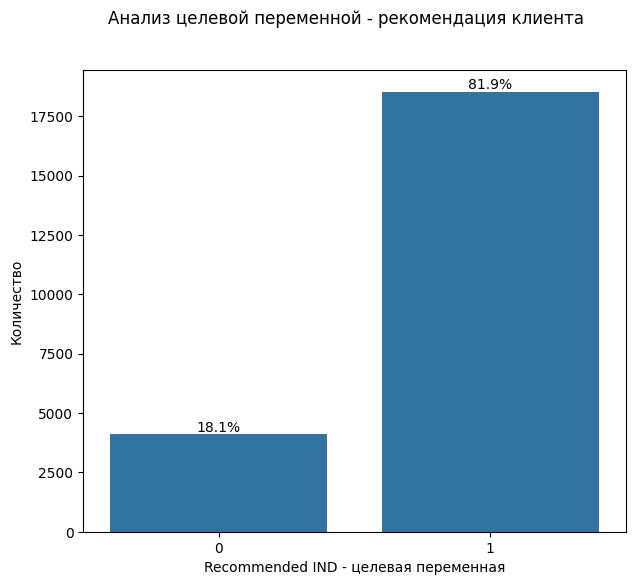

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.countplot(x="Recommended IND", data=df_cleared)

ax.set_ylabel("Количество")
ax.set_xlabel("Recommended IND - целевая переменная")

total = df_cleared["Recommended IND"].count()
ax.bar_label(ax.containers[0], fmt=lambda x: f"{(x/total)*100:0.1f}%")

plt.suptitle("Анализ целевой переменной - рекомендация клиента")
plt.show()

- Данные сильно несбалансированны. Более 82% данных отностятся к классу 1 (клиент рекомендовал бы товар) и менее 18% данных относятся к классу 1 (клиент не рекомендовал бы товар).
- В следстивии чего последующие прогнозы могут быть смещены в сторону клиентов **с положительной рекомендацией товара**.

# 6 Загрузка модели и подготовка датасета к обучению

## 6.1 Загрузка модели

В данной работе рассмотрим [T5](https://huggingface.co/ai-forever/ruT5-base) . Модель небольшого размера, при этом обладает достаточными для решения задачи метриками.

В реально проекте пользуясь [фильтрами](https://huggingface.co/models?pipeline_tag=text-classification&language=ru&sort=downloads) можно выбрать SOTA для языка, преобладающего в вашем датасете.

In [ ]:
model_name = "ai-forever/ruT5-base"
# model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
# есть предобученная модель - укажем название папки с бинарником и конфигами
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruT5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_feat

## 6.2 Подготовка датасета

In [ ]:
full_dataset = load_dataset("csv", data_files=f"{PATH_DATA}/df_cleared.csv")
# Фильтрация записей, в которых текстовые поля или метки не являются None
# full_dataset = full_dataset.filter(lambda example: example['text'] is not None and example['labels'] is not None)

full_dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Review Text', 'Recommended IND'],
        num_rows: 22634
    })
})

In [ ]:
tokenizer.tokenize(full_dataset["train"][1]["Review Text"])

['▁lo',
 've',
 '▁',
 'dr',
 'ess',
 '▁so',
 'oo',
 '▁pre',
 't',
 'ty',
 '▁h',
 'app',
 'en',
 'ed',
 '▁find',
 '▁st',
 'ore',
 '▁g',
 'lad',
 '▁b',
 'c',
 '▁ne',
 'ver',
 '▁would',
 '▁order',
 'ed',
 '▁online',
 '▁b',
 'c',
 '▁p',
 'et',
 'ite',
 '▁bo',
 'ug',
 'h',
 't',
 '▁p',
 'et',
 'ite',
 '▁5',
 '▁8',
 '▁lo',
 've',
 '▁length',
 '▁h',
 'it',
 '▁li',
 'ttle',
 '▁k',
 'ne',
 'e',
 '▁would',
 '▁de',
 'fin',
 'ite',
 'ly',
 '▁',
 'true',
 '▁mi',
 'di',
 '▁some',
 'one',
 '▁t',
 'ru',
 'ly',
 '▁p',
 'et',
 'ite']

In [ ]:
# разделим на обучающую и тестовую
dataset = full_dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['Review Text', 'Recommended IND'],
        num_rows: 18107
    })
    test: Dataset({
        features: ['Review Text', 'Recommended IND'],
        num_rows: 4527
    })
})

In [ ]:
pd.Series(dataset["test"]["Recommended IND"]).value_counts()

1    3694
0     833
Name: count, dtype: int64

In [ ]:
# визуализируем один пример
dataset["train"][0]

{'Review Text': 'glad gave try last summer peachy pink color year got darker grey color great go much soft comfortable also love work rolled bottom',
 'Recommended IND': 1}

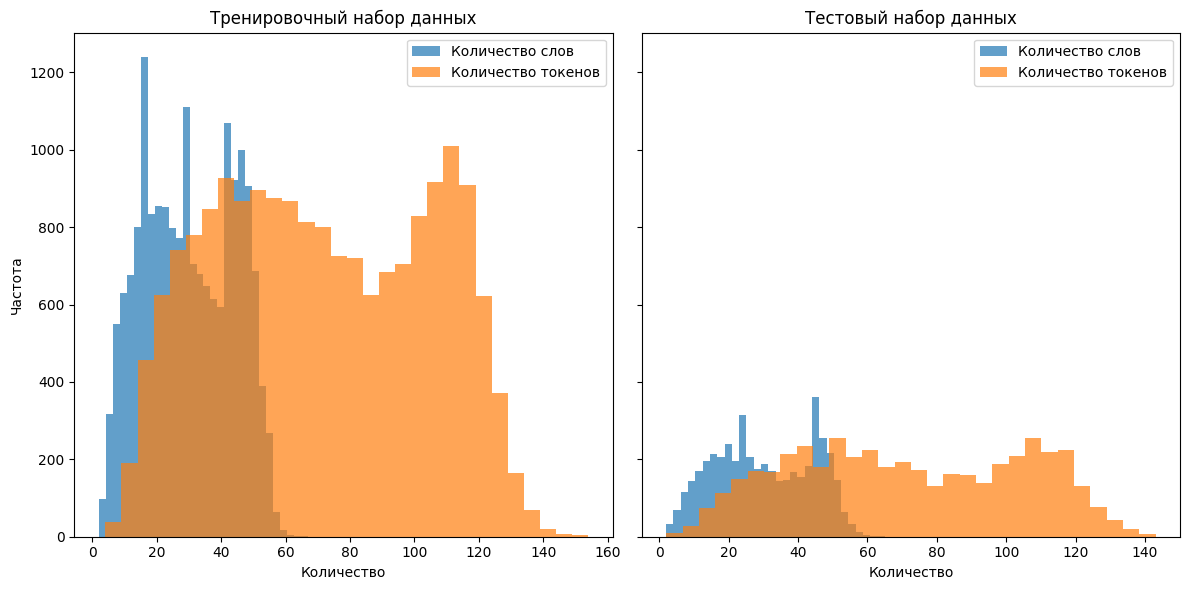

In [ ]:
# Подсчет количества слов и токенов с использованием токенизатора
train_word_counts = [
    len(example["Review Text"].split()) for example in dataset["train"]
]

train_token_counts = [
    len(tokenizer.tokenize(example["Review Text"])) for example in dataset["train"]
]

test_word_counts = [len(example["Review Text"].split()) for example in dataset["test"]]
test_token_counts = [
    len(tokenizer.tokenize(example["Review Text"])) for example in dataset["test"]
]

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Гистограмма для тренировочного набора данных
axes[0].hist(train_word_counts, bins=30, alpha=0.7, label="Количество слов")
axes[0].hist(train_token_counts, bins=30, alpha=0.7, label="Количество токенов")
axes[0].set_title("Тренировочный набор данных")
axes[0].set_xlabel("Количество")
axes[0].set_ylabel("Частота")
axes[0].legend()

# Гистограмма для тестового набора данных
axes[1].hist(test_word_counts, bins=30, alpha=0.7, label="Количество слов")
axes[1].hist(test_token_counts, bins=30, alpha=0.7, label="Количество токенов")
axes[1].set_title("Тестовый набор данных")
axes[1].set_xlabel("Количество")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
dataset = dataset.map(
    lambda e: tokenizer(
        e["Review Text"], truncation=True, max_length=80, padding="max_length"
    ),
    batched=True,
)

Map:   0%|          | 0/18107 [00:00<?, ? examples/s]

Map:   0%|          | 0/4527 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Review Text', 'Recommended IND', 'input_ids', 'attention_mask'],
        num_rows: 18107
    })
    test: Dataset({
        features: ['Review Text', 'Recommended IND', 'input_ids', 'attention_mask'],
        num_rows: 4527
    })
})

In [ ]:
# текст был успешно закодирован, более он нам не нужен
dataset = dataset.remove_columns("Review Text")

In [ ]:
# переносим на гпу
dataset.set_format(type="torch", device="cuda")

In [ ]:
# создаем загрузчики данных
train_dataloader = DataLoader(
    dataset["train"], shuffle=True, batch_size=16, pin_memory=False
)
test_dataloader = DataLoader(
    dataset["test"], shuffle=False, batch_size=8, pin_memory=False
)

Что подается на вход модели?

- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **Recommended IND**: (в случае обучения) вектор из нулей и единиц. В нашем случае нули обозначают негативную рекомендацию, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
next(iter(train_dataloader))

{'Recommended IND': tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'input_ids': tensor([[    8, 26361,     8,  ...,     0,     0,     0],
         [ 4245,   822,  4877,  ...,   225,     8,     2],
         [17188,  9643,  1274,  ...,  2367,  2496,     2],
         ...,
         [    8, 13820, 11851,  ..., 13114,   225,     2],
         [    8, 16758,     8,  ..., 20839,   705,     2],
         [17188,  9643,  1274,  ...,     0,     0,     0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

# 7 Инициализация и обучение моделей

In [ ]:
# оптимизатор AdamW, лр стоит поперебирать
optimizer = AdamW(model.parameters(), lr=1e-4)
# количество эпох можно побольше поставить
num_epochs = 3
# количество шагов
num_training_steps = num_epochs * len(train_dataloader)

# будем линейно увеличивать первые 200 шагов
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=int(
        0.1 * num_epochs * len(train_dataloader)
    ),  # ~10% от общего числа шагов оптимально
    num_training_steps=num_training_steps,
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Задаем начальное значение лучшего F1
best_f1 = 0.0

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'

running_loss = []
# Проходимся по всем эпохам
for epoch in range(num_epochs):
    print(40 * "-", f"\nEpoch {epoch+1}")

    # Переводим модель в режим обучения
    model.train()
    pbar = tqdm(train_dataloader, total=len(train_dataloader), desc="Training")

    # Итерируемся по данным для обучения
    for i, batch in enumerate(pbar):
        # Переводим данные на gpu
        batch = {k: v.to(device) for k, v in batch.items()}

        # Обновляем ключ метки класса
        batch["labels"] = batch.pop("Recommended IND")

        # Получаем прогнозы и потери от модели
        outputs = model(**batch)
        loss = outputs.loss

        # Выполняем обратное распространение и шаг оптимизатора
        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # Обновляем планировщик скорости обучения
        optimizer.zero_grad()  # Очищаем градиенты

        running_loss.append(loss.item())
        pbar.set_postfix({"running_loss": np.mean(running_loss[-25:])})

    # Валидация модели
    print("\nValidating...")
    model.eval()  # Переводим модель в режим валидации

    # Инициализируем метрики
    f1 = load_metric("f1", trust_remote_code=True)
    acc = load_metric("accuracy", trust_remote_code=True)
    precision = load_metric("precision", trust_remote_code=True)
    recall = load_metric("recall", trust_remote_code=True)

    val_loss = []

    pbar = tqdm(test_dataloader, total=len(test_dataloader), desc="Validation")
    # Итерируемся по валидационным данным
    for batch in tqdm(pbar):
        # Переводим данные на gpu
        batch = {k: v.to(device) for k, v in batch.items()}

        # Обновляем ключ метки класса
        batch["labels"] = batch.pop("Recommended IND")

        with torch.no_grad():  # Выполняем без расчета градиентов
            outputs = model(**batch)

        logits = outputs.logits.detach().cpu()
        predictions = torch.argmax(logits, dim=-1)

        # Обновляем метрики
        f1.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        acc.add_batch(
            predictions=predictions, references=batch["labels"].detach().cpu()
        )
        precision.add_batch(
            predictions=predictions, references=batch["labels"].detach().cpu()
        )
        recall.add_batch(
            predictions=predictions, references=batch["labels"].detach().cpu()
        )

        # Сохраняем потери
        val_loss.append(outputs.loss.item())
        pbar.set_postfix({"val_loss": np.mean(val_loss[-25:])})

    # Выводим итоги по метрикам
    print("Weighted Summary:")
    test_acc = acc.compute()["accuracy"]
    test_precision = precision.compute(average="weighted")["precision"]
    test_recall = recall.compute(average="weighted")["recall"]
    f1_weighted = f1.compute(average="weighted")["f1"]
    print(f"[{epoch+1}] Test Accuracy: {test_acc:.4f}")
    print(f"[{epoch+1}] Test Precision: {test_precision:.4f}")
    print(f"[{epoch+1}] Test Recall: {test_recall:.4f}")
    print(f"[{epoch+1}] Test F1: {f1_weighted:.4f}")

    # Сохраняем модель при улучшении F1
    if f1_weighted > best_f1:
        best_f1 = f1_weighted
        model.save_pretrained(f"best_model_nov_2021_f1_max={best_f1}_len=100")
        print(f"New best F1: {best_f1}. Model saved.")

---------------------------------------- 
Epoch 1


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


<ipython-input-46-f95fee7a542d>:42: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  f1 = load_metric('f1', trust_remote_code=True)


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[1] Test Accuracy: 0.8160
[1] Test Precision: 0.6658
[1] Test Recall: 0.8160
[1] Test F1: 0.7333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


New best F1: 0.7333117353670352. Model saved.
---------------------------------------- 
Epoch 2


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[2] Test Accuracy: 0.8184
[2] Test Precision: 0.8132
[2] Test Recall: 0.8184
[2] Test F1: 0.7407
New best F1: 0.7406936835859554. Model saved.
---------------------------------------- 
Epoch 3


Training:   0%|          | 0/1132 [00:00<?, ?it/s]


Validating...


Validation:   0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

Weighted Summary:
[3] Test Accuracy: 0.8191
[3] Test Precision: 0.7847
[3] Test Recall: 0.8191
[3] Test F1: 0.7490
New best F1: 0.7489929978139275. Model saved.
